<a href="https://colab.research.google.com/github/RFATS/VisionDetection/blob/exam/3.%20Projects/Final%20Project_answer/%5BFinal%20Project%5D%201.%20MVTecAD%20Classification_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.cpu_count()

12

In [3]:
# ==================================================
# 0. 의존성 & 전역 설정
# ==================================================
import os, random, time
from pathlib import Path
from typing import List, Tuple

import torch, torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from tqdm import tqdm
import matplotlib.pyplot as plt

# ------------------------------
# 사용자 하이퍼파라미터
# ------------------------------
ROOT_DIR   = "/content/drive/MyDrive/Data/MVTecAD"  # 데이터셋 경로
IMG_SIZE   = 224
BATCH_SIZE = 32
VAL_RATIO  = 0.2
EPOCHS     = 10
LR         = 1e-4
BEST_PATH  = "best_model.pt"

# --------------------------------------------------
# 시드 고정
# --------------------------------------------------

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ 사용 디바이스:", DEVICE)


✅ 사용 디바이스: cuda


In [4]:
# ==================================================
# 1. Dataset (mask 제외 + 3채널 변환)
# ==================================================
class MVTecClsDataset(Dataset):
    """MVTecAD 전체 구조(train+test)를 한 번에 스캔해
    `category_defect` 단위 클래스로 만드는 Dataset.
    • train/ 하위는 항상 `good` 이므로 라벨 = f"{category}_good"
    • test/ 하위는 결함 폴더(예: broken_large)를 그대로 라벨에 사용
    • 파일명에 `mask` 포함 시 제외
    • 모든 이미지는 3채널(RGB)로 강제 변환
    """

    VALID_EXT = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
    HIDDEN    = {".ipynb_checkpoints", ".DS_Store"}

    def __init__(self, root_dir: str, transforms=None):
        self.root = Path(root_dir)
        self.t    = transforms
        self.samples: List[Tuple[Path, int]] = []
        self.classes: List[str] = []
        self._scan()

    def _scan(self):
        lbl2idx = {}
        for p in self.root.rglob("*"):
            # --- 유효 파일 필터 ---
            if not (p.is_file() and p.suffix.lower() in self.VALID_EXT):
                continue
            if any(h in p.parts for h in self.HIDDEN):
                continue
            if "mask" in p.stem.lower():
                continue
            parts = p.relative_to(self.root).parts  # (category, train/test, defect?, img)
            if len(parts) < 3:
                continue
            category, phase = parts[0], parts[1]
            defect = "good" if phase == "train" else parts[2]
            lbl_name = f"{category}_{defect}"
            cls_idx = lbl2idx.setdefault(lbl_name, len(lbl2idx))
            self.samples.append((p, cls_idx))

        self.classes = [lbl for lbl, _ in sorted(lbl2idx.items(), key=lambda kv: kv[1])]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        p, label = self.samples[idx]
        img = torchvision.io.read_image(str(p)).float() / 255.0
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)
        elif img.shape[0] == 4:
            img = img[:3]
        if self.t:
            img = self.t(img)
        return img, label, str(p)




In [5]:
# ==================================================
# 2. DataLoader
# ==================================================
train_tfms = T.Compose([T.Resize((IMG_SIZE,IMG_SIZE)), T.RandomHorizontalFlip(), T.RandomRotation(10)])
val_tfms = T.Resize((IMG_SIZE,IMG_SIZE))

base_ds = MVTecClsDataset(ROOT_DIR)
indices = list(range(len(base_ds)))
random.shuffle(indices)
val_len = int(len(indices)*VAL_RATIO)
val_idx,train_idx = indices[:val_len],indices[val_len:]
train_set, val_set = Subset(base_ds, train_idx), Subset(base_ds, val_idx)

make_loader = lambda ds,tfm,shuf: DataLoader(ds,batch_size=BATCH_SIZE,shuffle=shuf,
                                             num_workers=2 if torch.cuda.is_available() else 0,
                                             pin_memory=torch.cuda.is_available(),
                                             collate_fn=lambda b:(torch.stack([tfm(x[0]) for x in b]),
                                                                torch.tensor([x[1] for x in b]),
                                                                [x[2] for x in b]))
train_loader = make_loader(train_set,train_tfms,True)
val_loader = make_loader(val_set,val_tfms,False)
idx2lbl=base_ds.classes
print("클래스:", idx2lbl)



클래스: ['leather_color', 'leather_poke', 'leather_glue', 'leather_good', 'leather_fold', 'leather_cut', 'cable_missing_wire', 'cable_cut_outer_insulation', 'cable_good', 'cable_bent_wire', 'cable_cable_swap', 'cable_poke_insulation', 'cable_missing_cable', 'cable_combined', 'cable_cut_inner_insulation', 'capsule_good', 'capsule_crack', 'capsule_scratch', 'capsule_poke', 'capsule_faulty_imprint', 'capsule_squeeze', 'hazelnut_good', 'hazelnut_print', 'hazelnut_crack', 'hazelnut_hole', 'hazelnut_cut', 'bottle_broken_large', 'bottle_broken_small', 'bottle_contamination', 'bottle_good', 'carpet_color', 'carpet_metal_contamination', 'carpet_good', 'carpet_thread', 'carpet_cut', 'carpet_hole', 'metal_nut_color', 'metal_nut_good', 'metal_nut_scratch', 'metal_nut_bent', 'metal_nut_flip', 'screw_good', 'screw_scratch_neck', 'screw_scratch_head', 'screw_thread_top', 'screw_manipulated_front', 'screw_thread_side', 'pill_crack', 'pill_pill_type', 'pill_scratch', 'pill_color', 'pill_good', 'pill_fault

In [6]:
# ==================================================
# 3. 모델 정의
# ==================================================
# pretrained EfficientNet B0 사용
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

# 분류기 헤드 교체
num_classes = len(idx2lbl)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes)
)

model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 144MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Validating: 100%|██████████| 34/34 [05:45<00:00, 10.15s/it]


✓ 모델 저장됨: best_model.pt (acc=0.7794)
Epoch 1/10 - Train Loss: 1.9852, Train Acc: 0.7080, Val Loss: 1.0213, Val Acc: 0.7794


Validating: 100%|██████████| 34/34 [00:23<00:00,  1.44it/s]


✓ 모델 저장됨: best_model.pt (acc=0.7972)
Epoch 2/10 - Train Loss: 0.9888, Train Acc: 0.7626, Val Loss: 0.7765, Val Acc: 0.7972


Validating: 100%|██████████| 34/34 [00:23<00:00,  1.43it/s]


✓ 모델 저장됨: best_model.pt (acc=0.8224)
Epoch 3/10 - Train Loss: 0.8041, Train Acc: 0.7803, Val Loss: 0.6132, Val Acc: 0.8224


Validating: 100%|██████████| 34/34 [00:24<00:00,  1.41it/s]


✓ 모델 저장됨: best_model.pt (acc=0.8336)
Epoch 4/10 - Train Loss: 0.6885, Train Acc: 0.8084, Val Loss: 0.5280, Val Acc: 0.8336


Validating: 100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


✓ 모델 저장됨: best_model.pt (acc=0.8551)
Epoch 5/10 - Train Loss: 0.5668, Train Acc: 0.8340, Val Loss: 0.5031, Val Acc: 0.8551


Validating: 100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


✓ 모델 저장됨: best_model.pt (acc=0.8701)
Epoch 6/10 - Train Loss: 0.4859, Train Acc: 0.8585, Val Loss: 0.3988, Val Acc: 0.8701


Validating: 100%|██████████| 34/34 [00:23<00:00,  1.44it/s]


✓ 모델 저장됨: best_model.pt (acc=0.8850)
Epoch 7/10 - Train Loss: 0.4115, Train Acc: 0.8758, Val Loss: 0.3397, Val Acc: 0.8850


Validating: 100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


✓ 모델 저장됨: best_model.pt (acc=0.9019)
Epoch 8/10 - Train Loss: 0.3532, Train Acc: 0.8947, Val Loss: 0.3081, Val Acc: 0.9019


Validating: 100%|██████████| 34/34 [00:23<00:00,  1.44it/s]


✓ 모델 저장됨: best_model.pt (acc=0.9084)
Epoch 9/10 - Train Loss: 0.3198, Train Acc: 0.9008, Val Loss: 0.2854, Val Acc: 0.9084


Validating: 100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


✓ 모델 저장됨: best_model.pt (acc=0.9140)
Epoch 10/10 - Train Loss: 0.2794, Train Acc: 0.9169, Val Loss: 0.2700, Val Acc: 0.9140


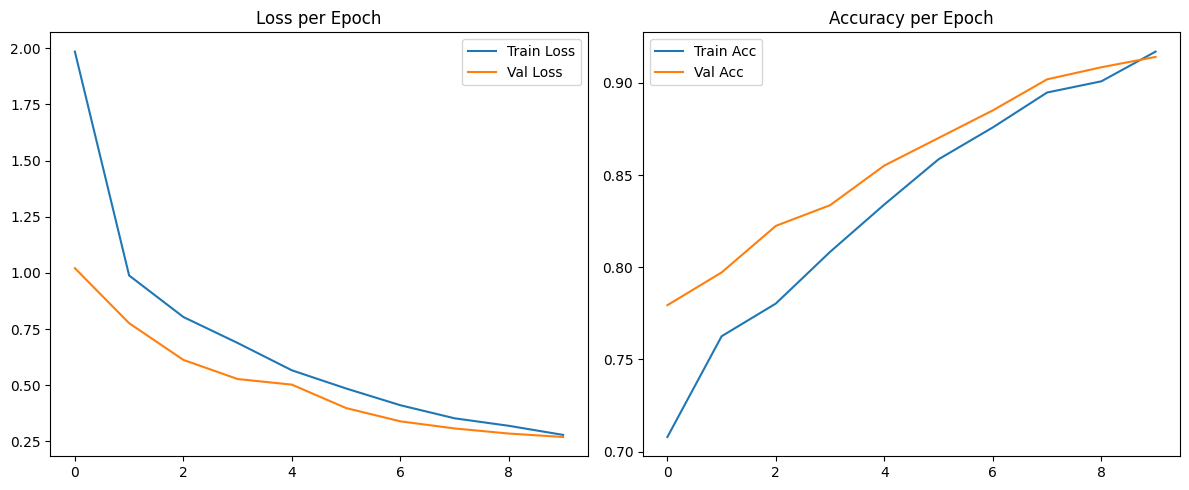

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [7]:
# ==================================================
# 4. 학습 루프
# ==================================================
best_acc = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, EPOCHS + 1):
    # ---- Train ----
    model.train()
    train_loss, correct, total = 0, 0, 0

    for imgs, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # ---- Validate ----
    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.inference_mode():
        for imgs, labels, _ in tqdm(val_loader, desc="Validating"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # 스케줄러 & 최적 모델 저장
    scheduler.step(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), BEST_PATH)
        print(f"✓ 모델 저장됨: {BEST_PATH} (acc={best_acc:.4f})")

    print(f"Epoch {epoch}/{EPOCHS} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# 학습 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy per Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# 최적 모델 로드
model.load_state_dict(torch.load(BEST_PATH))
model.eval()

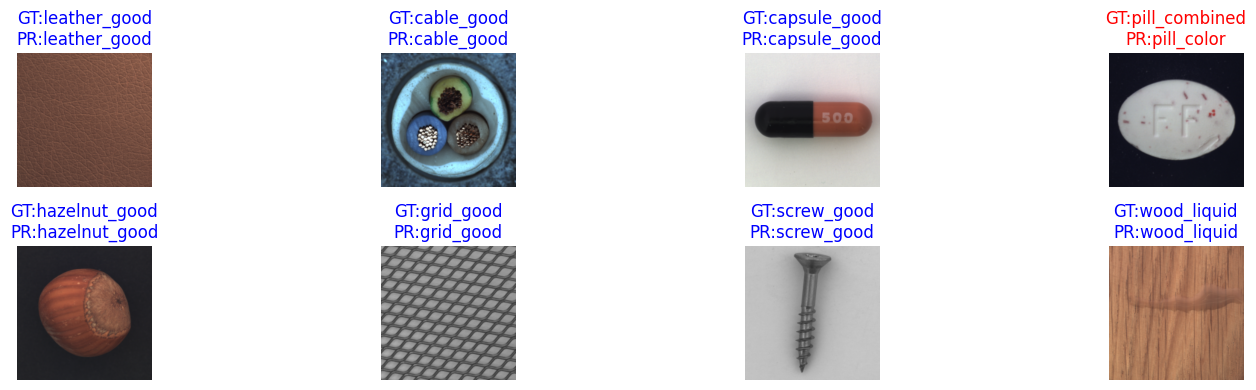

In [8]:
# ==================================================
# 5. 시각화 (파란=정답, 빨간=오답)
# ==================================================
# 검증 배치 GT vs 예측 (색상 구분)
model.eval(); val_imgs,val_labels, _ = next(iter(val_loader))
with torch.inference_mode(): preds = model(val_imgs.to(DEVICE)).argmax(1).cpu()
plt.figure(figsize=(16,4))
for i in range(8):
    correct=preds[i]==val_labels[i]; color='blue' if correct else 'red'
    plt.subplot(2,4,i+1)
    plt.imshow(val_imgs[i].permute(1,2,0))
    plt.title(f"GT:{idx2lbl[int(val_labels[i])]}\nPR:{idx2lbl[int(preds[i])]}", color=color)
    plt.axis('off')
plt.tight_layout(); plt.show()